<a href="https://colab.research.google.com/github/lmendezayl/uba-ldd-tp1/blob/main/TP_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis Exploratorio de Educación vs. Condiciones Habitacionales (Censo 2022)

---

### Autor 
Lautaro Evaristo Méndez 
[lmendezayl@gmail.com](mailto:lmendezayl@gmail.com) | [LinkedIn](https://www.linkedin.com/in/tu-perfil)  

*Trabajo realizado para la Licenciatura en Ciencias de Datos, Universidad de Buenos Aires*  

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split

---

### Tabla de Contenidos
1. [Introducción](#Introducción)  
2. [Hipótesis Inicial](#Hipótesis-Inicial)  
3. [Metodología](#metodología)
   - 3.1 [Carga de Datos](#carga-de-datos)  
   - 3.2 [Limpieza y Normalización](#limpieza-y-normalización)  
   - 3.3 [Preprocesamiento](#preprocesamiento)  
4. [Análisis de Correlación](#análisis-de-correlación)  
   - 4.1 [Conclusiones](#conclusiones)  
   - 4.2 [Nueva Hipótesis](#nueva-hipótesis)
5. [Modelado de Ajuste Lineal](#modelado-de-ajuste-lineal)  



---

### Introducción

Trabajaremos con los datos publicados en el [Manual Metodológico de Indicadores Educativos](https://abc.gob.ar/secretarias/sites/default/files/2021-08/MANUAL%20METODOLÓGICO%20DE%20INDICADORES%20EDUCATIVOS-%202021.pdf), que contiene mediciones de variables educativas de la escuela primaria y secundaria en la Provincia de Buenos Aires (PBA) desde 2012 a 2022. Lo llamaremos `df_educacion`.

Tambien usaremos los datos publicados en ["*Censo Nacional de Población, Hogares y Viviendas 2022, Resultados provisionales, Indicadores de las condiciones habitacionales de las viviendas particulares ocupadas*"](https://www.indec.gob.ar/ftp/cuadros/poblacion/cnphv2022_condiciones_habitacionales_05_23A5A5DCDF38.pdf). En particular, nos interesa el apartado de estadísticas de la Provincia de Buenos Aires, en las páginas 14 a 17 (inclusive). Lo llamaremos `df_censo_2022_cond_hab`.

Sumado a esto, añadimos como análisis posterior de la hipótesis inicial entrenar un modelo que a partir de los datos de condiciones habitacionales de 2022, sea capaz de predecir algunas de las tasas de educación para el año 2022. Véase: [Modelado de Ajuste Lineal](#Modelado-de-ajuste-lineal)

Como solo tenemos datos sobre las condiciones habitacionales del último censo, tenemos una limitación muy estricta. Debido a esto, la metodología que usaremos será tomar una fraccion de partidos como conjunto de entrenamiento y otra como conjunto de testeo, de esta forma verificamos la vericidad del modelo.

A su vez, sería interesante poder dar una estimación preliminar sobre los datos de educación de 2023 usando el modelo asumiendo que las condiciones habitacionales se mantienen constantes, pero no podriamos verificarlos pues no hay datos publicados de 2023. Aún si intentaramos predecir años posteriores, está claro que a más alejado el año se encuentra de 2022, mayor sería el error de la predicción realizada por el modelo. 

Por otro lado, no podemos intentar predecir los datos de 2021 y de 2020, ya que poseen un sesgo muy marcado por la pandemia de COVID-19 y es por este motivo que deben ser considerados casos aislados. Años pre-pandemia no son comparables debido a diferencias estructurales en el sistema educativo, como la virtualidad como norma, colegios menos restrictivos, entre otros cambios.


A continuación, una breve descripcion de las variables en ambos conjuntos de datos.


| Variable | Descripción |
|----------|-------------|
| **pisos_revestimiento** | El material predominante de los pisos es cerámica, mosaico, baldosa, alfombra, madera, flotante, vinílico, microcemento, cemento alisado o mármol. |
| **agua_caneria_vivienda** | Tiene agua por cañería dentro de la vivienda (binario: Sí/No). |
| **agua_red_publica** | El agua para beber/cocinar proviene de red pública (agua corriente). |
| **banio_letrina** | Tiene baño o letrina dentro de la vivienda. |
| **banios_multiples** | Tiene dos o más baños. |
| **banio_arrastre_agua** | El baño posee inodoro con arrastre de agua (botón, mochila o cadena). |
| **desague_red_publica** | El desagüe del inodoro va a red pública (cloaca). |
| **cocina_gas_electricidad** | Utiliza gas de red o electricidad como principal fuente para cocinar. |
| **vivienda_propia** | La vivienda es de propiedad del hogar. |
| **internet** | Tiene conexión a internet en el hogar. |
| **celular_internet** | Tiene celular con acceso a internet. |
| **dispositivos_digitales** | Posee computadora, tablet u otros dispositivos digitales. |

Tabla 1: Variables de Condiciones Habitacionales

| Variable | Descripción |
|----------|-------------|
| **anio** | Año de medición de los datos. |
| **municipio_id** | Identificador numérico único del municipio. |
| **municipio_nombre** | Nombre oficial del municipio. |
| **promocion_efectiva_X** | % de alumnos que pasan al siguiente grado en el mismo nivel educativo. |
| **repitencia_X** | % de alumnos que repiten el mismo grado en el siguiente año lectivo. |
| **reinscripcion_X** | % de alumnos que abandonan y se reinscriben en el mismo grado. |
| **abandono_interanual_X** | % de alumnos que no se matriculan al año siguiente (nuevos, repitentes o reinscriptos). |
| **alumnos_promovidos_X** | % de alumnos que aprobaron todas las materias y pasaron de grado. |
| **alumnos_no_promovidos_X** | % de alumnos que no cumplieron los requisitos para pasar de grado. |
| **salidos_sin_pase_X** | % de alumnos que dejaron la escuela sin trámite de pase. |
| **salidos_con_pase_X** | % de alumnos que dejaron la escuela con trámite de pase. |
| **sobreedad_X** | % de alumnos con edad superior a la teórica para su grado. |
| **sobreedad_avanzada_X** | % de alumnos con 2+ años de diferencia sobre la edad teórica. |

Tabla 2: Variables de Indicadores Educativos (Reemplazar `X` por `primaria` o `secundaria`)


### Hipótesis Inicial

En este análisis intentaremos dar una respuesta a la siguiente hipótesis:
> *Los municipios con peores condiciones habitacionales en 2022 tienen mayores tasas de abandono y/o repitencia en 2022.*

Es un buen puntapié, ya que la precariedad habitacional suele estar relacionada con la vulnerabilidad socioeconómica, que impacta en la asistencia y desempeño escolar.

### Metodología

#### Carga de Datos

Importamos los datasets con los que trabajaremos:

In [4]:
# Cargamos DataFrame de condiciones habitacionales
df_censo_2022_cond_hab = pd.read_csv('./data/censo2022_cond_hab.csv')
df_censo_2022_cond_hab.dropna()

# Cargamos DataFrame de indicadores de educación
df_educacion = pd.read_csv('data/indicadores-educativos-2012_2022.csv')
df_educacion = df_educacion.dropna()

Echémosle un vistazo a los datos con los que trabajaremos:

In [5]:
display(df_censo_2022_cond_hab.head())

,Partido,Pisos con revestimiento,Agua por canieria dentro de la vivienda,Agua para beber y cocinar por red publica,Banio o letrina dentro de la vivienda,Dos o mas banios,Banio con inodoro con arrastre de agua,Desague del inodoro del banio a red publica,Gas de red o electricidad para cocinar,Vivienda propia,Internet,Celular con internet,Computadora o tablet u otros
0,Almirante Brown,83.7,90.5,54.8,96.3,20.3,85.4,41.4,65.1,73.3,83.0,91.6,55.9
1,Avellaneda,92.9,96.4,96.6,96.4,23.7,94.3,81.1,78.2,64.0,85.6,92.4,65.3
2,Berazategui,85.8,95.0,89.8,96.7,23.1,90.0,77.1,67.4,71.1,86.3,92.7,58.3
3,Esteban Echeverría,81.1,89.4,61.0,95.9,23.3,84.8,50.4,61.2,70.4,82.4,92.1,54.5
4,Ezeiza,78.0,87.7,49.4,96.0,20.0,82.8,35.7,55.0,72.9,76.8,91.7,51.4


In [6]:
df_educacion.head()

,anio,municipio_id,municipio_nombre,promocion_efectiva_primaria,promocion_efectiva_secundaria,repitencia_primaria,repitencia_secundaria,reinscripcion_primaria,reinscripcion_secundaria,abandono_interanual_primaria,...,alumnos_no_promovidos_primaria,alumnos_no_promovidos_secundaria,salidos_sin_pase_primaria,salidos_sin_pase_secundaria,salidos_con_pase_primaria,salidos_con_pase_secundaria,sobreedad_primaria,sobreedad_secundaria,sobreedad_avanzada_primaria,sobreedad_avanzada_secundaria
0,2012,6007,Adolfo Alsina,100.26,84.14,1.25,9.06,0.07,1.79,-1.57,...,1.45,18.54,0.00,2.71,5.40,2.90,12.61,26.77,4.01,12.28
1,2013,6007,Adolfo Alsina,97.35,86.84,1.68,5.31,0.13,0.12,0.84,...,0.70,9.48,0.30,2.77,5.02,5.72,10.27,26.27,3.42,11.51
2,2014,6007,Adolfo Alsina,97.36,80.79,2.23,2.52,0.07,0.43,0.34,...,0.69,9.13,0.13,2.11,4.84,4.31,8.46,25.06,2.51,9.17
3,2015,6007,Adolfo Alsina,96.00,91.55,2.41,5.24,0.21,0.85,1.38,...,1.47,8.62,0.33,2.49,4.96,4.64,7.16,30.85,1.86,10.51
4,2016,6007,Adolfo Alsina,97.67,95.56,2.61,7.27,0.07,1.29,-0.35,...,1.58,6.95,0.14,2.79,4.72,3.57,6.81,26.13,1.69,8.24


 Antes de crear el modelo, debemos limpiar, preprocesar, y filtrar los datos para lograr lo que deseamos. Primero, limpiemos los datos y normalizemos el formato.

#### Limpieza y normalización


Para facilitar el merge entre nuestro dataset y la subtabla de `df_educacion` con datos de 2022 que crearemos luego, normalizamos los nombres de los municipios eliminando tildes y unificando el nombre de la columna. También ordenamos el dataframe.


In [7]:
import re
cambiar_tildes = {"á": "a", "é": "e", "í": "i", "ó": "o", "ú": "u", "ü": "u"}
pattern = re.compile("|".join(cambiar_tildes.keys()))

# Funcion para sacar tildes de nombres
def destildar(texto):
    return pattern.sub(lambda x: cambiar_tildes[x.group()], texto)

# Limpiamos tildes de nombres de partidos por letras sin tilde
df_censo_2022_cond_hab['Partido'] = df_censo_2022_cond_hab['Partido'].apply(destildar)

# Formateamos la tabla
df_censo_2022_cond_hab = (
    df_censo_2022_cond_hab
    .rename(columns={"Partido" : 'municipio_nombre'}) # Igualamos nombre de columna de df_educacion para poder realizar un merge
    .set_index('municipio_nombre')
    .sort_index()
    .reset_index())

Verificamos que tengamos los mismos municipios en ambas tablas poder hacer un merge usando una comparacion con un set para poder ignorar orden de datos.


In [8]:
set_censo = set(df_censo_2022_cond_hab['municipio_nombre'].unique().tolist())
set_educ = set(df_educacion['municipio_nombre'].unique().tolist())
print(set_censo == set_educ)

True


Entonces, como ambas columnas tienen los mismos municipios, usar el metodo `sort_index()` al crear la tabla en ambos casos garantiza el mismo orden de valores, y de esta forma crear una matriz de correlacion que sea valida.

A continuacion creamos la subtabla de `df_educacion` que solo contenga los datos de 2022 mencionada anteriormente con las columnas que nos sirven:

In [9]:
df_educacion_2022 = (
    df_educacion[df_educacion['anio'] == 2022]
    .set_index('municipio_nombre') # hacemos el mismo proceso de indexacion que para df_censo_2022_cond_hab
    .sort_index()
    .reset_index()
    .drop(columns = ['anio', 'zona', 'mayor_repitencia_primaria']))

KeyError: "['zona', 'mayor_repitencia_primaria'] not found in axis"

Por una cuestion de minimizar la perdida de datos, es conveniente crear un mapeo entre los nombres y los ID de municipio, ya que en el siguiente paso borraremos la columna de nombres para no tener que trabajar con datos tipo string.

In [ ]:
mapa_nombre_id = dict(zip(df_educacion_2022['municipio_id'], df_educacion_2022['municipio_nombre']))

# Por ejemplo, si queremos ver cual es el municipio con id=6854:
mapa_nombre_id[6854]

'25 de Mayo'

#### Preprocesamiento



Una vez que asignamos un ID unico a cada municipio, ya no es necesario trabajar con los nombres. Si en algún momento necesitamos consultar el nombre original, podemos usar el diccionario `mapa_nombre_id`.

También normalizamos los datos del censo para que estén en el rango [0, 1].

Ambos DataFrames ahora están ordenados de forma consistente, por lo que podemos agregar el `municipio_id` al DataFrame del censo y realizar `merge` usando esa clave.


In [ ]:
# Eliminamos los nombres de municipios, ya no los necesitamos
df_educacion_2022 = df_educacion_2022.drop(columns='municipio_nombre')
df_censo_2022_cond_hab = df_censo_2022_cond_hab.drop(columns='municipio_nombre')

# Normalizamos los datos del censo (de 0 a 1)
df_censo_2022_cond_hab = df_censo_2022_cond_hab/100

# Agregamos el ID de municipio al dataframe del censo
df_censo_2022_cond_hab["municipio_id"] = df_educacion_2022['municipio_id']

# Merge final para obtener el dataframe combinado
df = pd.merge(df_censo_2022_cond_hab, df_educacion_2022, on='municipio_id', how="inner")

# Reordenamos las columnas
df = df[['municipio_id', 'Pisos con revestimiento',
       'Agua por canieria dentro de la vivienda',
       'Agua para beber y cocinar por red publica',
       'Banio o letrina dentro de la vivienda', 'Dos o mas banios',
       'Banio con inodoro con arrastre de agua',
       'Desague del inodoro del banio a red publica',
       'Gas de red o electricidad para cocinar', 'Vivienda propia', 'Internet',
       'Celular con internet', 'Computadora o tablet u otros',
       'promocion_efectiva_primaria', 'promocion_efectiva_secundaria',
       'repitencia_primaria', 'repitencia_secundaria',
       'reinscripcion_primaria', 'reinscripcion_secundaria',
       'abandono_interanual_primaria', 'abandono_interanual_secundaria',
       'alumnos_promovidos_primaria', 'alumnos_promovidos_secundaria',
       'alumnos_no_promovidos_primaria', 'alumnos_no_promovidos_secundaria',
       'salidos_sin_pase_primaria', 'salidos_sin_pase_secundaria',
       'salidos_con_pase_primaria', 'salidos_con_pase_secundaria',
       'sobreedad_primaria', 'sobreedad_secundaria',
       'sobreedad_avanzada_primaria', 'sobreedad_avanzada_secundaria']]

### Análisis de Correlación

Ya contamos con la base de datos formada, lo que nos permite comenzar a explorar las relaciones entre las variables. En particular, queremos identificar qué indicadores del censo podrían estar relacionados con indicadores de `df_educacion` con el objetivo de elegir nuestras tasas objetivo a predecir en el modelo.

Para ello, utilizamos un **heatmap** que nos permite visualizar de forma intuitiva y con colores qué variables están más correlacionadas entre sí.


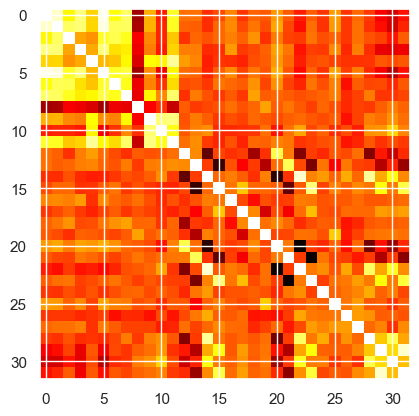

In [ ]:
# Creamos matriz de correlacion sin municipio_id
df_corr = df.drop(columns=['municipio_id']).corr()

# Creamos el heatmap
plt.imshow(df_corr,cmap='hot',interpolation='nearest')

No nos dice mucho este heatmap...

Veamos qué podemos mejorar. Nos interesaría identificar:
- qué variable educativa está **más correlacionada** con cada variable del censo.
- qué variable educativa está **menos correlacionada** con cada una.

Para eso, filtramos la matriz de correlación para quedarnos solo con los cruces entre ambos grupos de variables, ignorando las autocorrelaciones.


In [ ]:
# Filtramos la matriz de correlacion: filas = variables del censo, columnas = educativas
df_corr_subset = df_corr.iloc[:12, 12:]

# Reemplazamos los valores de autocorrelación (valor 1) por NaN para que no lo tomen como maximo/minimo
df_corr_subset = df_corr_subset.replace(1, np.nan)

# Maxima correlacion por variable del censo
max_values = df_corr_subset.max(axis=1)
max_columns = df_corr_subset.idxmax(axis=1)

# Minima correlacion por variable del censo
min_values = df_corr_subset.min(axis=1)
min_columns = df_corr_subset.idxmin(axis=1)

# Mostramos un dataframe para ver mejor los datos
display(pd.DataFrame({
    'Indicador con mayor correlacion positiva': max_columns,
    'Valor': max_values,
    'Indicador con mayor correlacion negativa': min_columns,
    'Valor ': min_values}))

,Indicador con mayor correlacion positiva,Valor,Indicador con mayor correlacion negativa,Valor
Pisos con revestimiento,salidos_sin_pase_secundaria,0.194875,sobreedad_avanzada_primaria,-0.404797
Agua por canieria dentro de la vivienda,alumnos_promovidos_primaria,0.232554,sobreedad_avanzada_primaria,-0.392229
Agua para beber y cocinar por red publica,abandono_interanual_primaria,0.164067,sobreedad_avanzada_primaria,-0.215006
Banio o letrina dentro de la vivienda,alumnos_promovidos_primaria,0.216062,sobreedad_avanzada_primaria,-0.346847
Dos o mas banios,promocion_efectiva_primaria,0.196569,repitencia_primaria,-0.184665
Banio con inodoro con arrastre de agua,alumnos_promovidos_primaria,0.247422,sobreedad_avanzada_primaria,-0.479238
Desague del inodoro del banio a red publica,abandono_interanual_primaria,0.168265,salidos_con_pase_primaria,-0.226960
Gas de red o electricidad para cocinar,abandono_interanual_primaria,0.215491,salidos_con_pase_primaria,-0.144385
Vivienda propia,abandono_interanual_secundaria,0.214668,salidos_con_pase_primaria,-0.153579
Internet,sobreedad_avanzada_primaria,0.166933,salidos_con_pase_primaria,-0.221059


Con estos datos, podemos hacer un análisis preliminar sobre las variables educativas que presentan la mayor y menor correlación con cada variable de condiciones habitacionales relevadas en el censo.

- La mayoría de las correlaciones positivas se encuentran entre **0.15 y 0.25**, lo que sugiere relaciones moderadas a débiles.
- Las correlaciones negativas son en varios casos más fuertes, destacándose:
  - Baño con inodoro con arrastre de agua y la sobreedad avanzada en primaria con **-0.48**
  - Pisos con revestimiento y la sobreedad avanzada en primaria con **-0.40**
- La variable de sobreedad avanzada en primaria es la que más apariciones tiene como mayor variable correlacionada negativamente, indicando que podría ser un buen candidato para variable objetivo para el modelo que queríamos implementar.

Finalmente, observemos el heatmap que originalmente quisimos implementar pero con los datos ya filtrados:

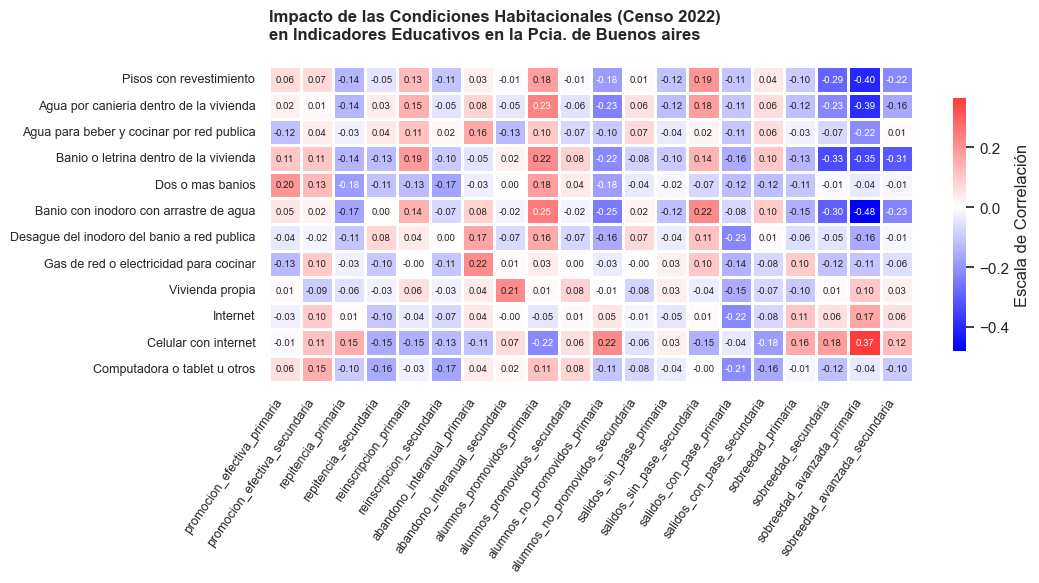

In [ ]:
# Creamos grafico
plt.figure(figsize=(11, 6))
ax = sns.heatmap(df_corr_subset, annot=True, annot_kws={"size": 7}, fmt=".2f", cmap="bwr", center=0, linewidths=1, cbar_kws={"shrink": 0.8, "label": "Escala de Correlación"})
plt.title("Impacto de las Condiciones Habitacionales (Censo 2022) \nen Indicadores Educativos en la Pcia. de Buenos aires", fontsize=12, pad=20, fontweight="bold", loc="left")
# Angulo de los ticks
ax.set_xticklabels(ax.get_xticklabels(), rotation=55, ha="right", fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)

plt.tight_layout()
plt.show()

#### Conclusiones

De este heatmap podemos extraer conclusiones para tomar en cuenta al diseñar nuestro modelo de predicción. Siguiendo el análisis preliminar anterior:

- "Baño con inodoro con arrastre de agua" tiene la correlación negativa más alta (-0.48) con sobreedad avanzada en primaria.
    - Una posible interpretación es que los municipios con mejor infraestructura sanitaria tienden a tener menos estudiantes con atraso escolar grave en primaria. Esto sugiere que condiciones básicas como saneamiento podrían favorecer el desarrollo educativo.

- "Pisos con revestimiento" tiene la segunda mayor correlación negativa, siendo esta una correlación moderada (-0.40) con sobreedad avanzada en primaria.
    - Una interpretacion que se puede considerar es que una mayor calidad de vivienda está asociada a un menor atraso escolar en primaria, reforzando el vínculo entre entorno y rendimiento educativo.

- En general, se observa que las condiciones habitacionales que reflejan falta de recursos básicos se correlacionan de forma positiva y débil con algunos indicadores que implican un resultado positivo en la educación, principalmente en la primaria.
    - Por ejemplo, la reinscripción de alumnos en primaria (0.13 a 0.19) y la promoción de alumnos en primaria (0.16 a 0.25).
- Mientras que por otro lado, estas también se correlacionan negativamente de forma moderada y débil con los indicadores que implican un resultado negativo en la cursada escolar. Nuevamente, esto se da principalmente en la primaria.
    - Por ejemplo, la repitencia de alumnos en primaria (-0.14 a -0.17), los alumnos no promovidos en primaria (-0.16 a -0.25), la sobreedad en primaria (-0.11 a -0.15), la sobreedad en secundaria (-0.23 a -0.33), y finalmente, la sobreedad avanzada en primaria (-0.35 a -0.48) y la sobreedad avanzada en secundaria (-0.16 a -0.31).
- Esto indica que los recursos básicos son esenciales para garantizar la continuidad escolar de los estudiantes, principalmente en primaria, ya que las condiciones habitacionales influyen con más fuerza en esos indicadores.
    - *Nota: Se propone como posible extension de la exploración poder identificar los hogares con niños en la primaria presentes y recrear el experimento con esa base de datos.*
    - *Nota (2): recordar que la promoción de alumnos en primaria tiene una relación (1:1) con la no promoción de alumnos en primaria, siendo una la inversa de la otra.*

- Por otro lado, "Celular con internet" tiene correlación positiva con la sobreedad avanzada en primaria (0.37). Una posible explicación es que el acceso a celulares sin supervisión podría distraer a los niños o reflejar desigualdades en el uso educativo de la tecnología, ya que no debemos olvidar que los datos sobre condiciones habitacionales son sobre hogares, y estos no discriminan si hay o no niños en los hogares encuestados.

- La condicion de poseer vivienda propia muestra correlaciones débiles (entre -0.10 y 0.10), sugiriendo que la tenencia de vivienda no es un factor determinante por sí solo.

- "Agua para beber por red pública" tiene correlaciones cercanas a cero (0.01 a 0.07) con la mayoría de indicadores educativos. Una posible razón es que el servicio podría estar universalizado en muchos municipios, reduciendo su poder discriminativo.

- "Dos o más baños" no muestra correlaciones fuertes (máx. 0.19), indicando que la cantidad de baños es menos relevante que su calidad (ej: arrastre de agua).


Cabe destacar también que la conclusión a este análisis no es lo suficientemente exhaustivo, pues también estamos tomando en consideración aquellos hogares que NO tienen niños presentes. Es por esto mismo que propusimos una extension al análisis donde solo se consideren hogares con esta condición.


#### Nueva Hipótesis

Con este análisis, proponemos un cambio de hipótesis a una que se adapte mejor a lo que pudimos observar. Véase:

> *La falta de saneamiento básico está más asociada al atraso escolar que al abandono inmediato en el ciclo escolar primario.*

Creemos que esta hipótesis se adapta mejor a lo que pudimos observar, y se puede justificar con las conclusiones que comentamos anteriormente. Principalmente debemos destacar que los indicadores considerados condiciones básicas tienen mayor correlación con la sobreedad avanzada en primaria, mientras que aquellos indicadores que tratan al abandono tienen una correlación más débil, que puede ser contraintuitivo a lo que uno se esperaría.

Consideramos como saneamiento básico los siguientes indicadores:
- Pisos con revestimiento
- Agua por cañeria dentro de la vivienda
- Baño o letrina dentro de la vivienda
- Baño con inodoro con arrastre de agua
- Desagüe del inodoro del banio a red pública

El siguiente gráfico presenta las correlaciones destacadas con estos indicadores:

In [ ]:
# Correlaciones negativas
df_corr_subset_negativas = (df_corr_subset
                            .drop(labels=['Agua para beber y cocinar por red publica', 'Dos o mas banios', 'Gas de red o electricidad para cocinar', 'Vivienda propia', 'Internet', 'Celular con internet', 'Computadora o tablet u otros'], axis=0)
                            .copy()[['abandono_interanual_primaria', 'repitencia_primaria', 'alumnos_no_promovidos_primaria','sobreedad_avanzada_primaria']])
# Correlaciones positivas
df_corr_subset_positivas = (df_corr_subset
                            .drop(labels=['Agua para beber y cocinar por red publica', 'Dos o mas banios', 'Gas de red o electricidad para cocinar', 'Vivienda propia', 'Internet', 'Celular con internet', 'Computadora o tablet u otros'], axis=0)
                            .copy()[['reinscripcion_primaria', 'alumnos_promovidos_primaria']])

# Configuracion gral para ambos heatmaps
plt.figure(figsize=(18, 8))
sns.set_theme(font_scale=1.0)
cmap = "vlag"
annot_kws = {"size": 12, "color": "black"}

# Correlaciones negativas (indicadores "malos")
plt.subplot(1, 2, 2)
ax1 = sns.heatmap(df_corr_subset_negativas, annot=True, fmt=".2f", cmap=cmap, center=0, vmin=-0.5, vmax=0.5, annot_kws=annot_kws, cbar_kws={"shrink": 0.7, "label": "Escala de Correlación", })
# Correlaciones positivas (indicadores "buenos")
plt.subplot(1, 2,1 )
ax2 = sns.heatmap(df_corr_subset_positivas, annot=True, fmt=".2f", cmap=cmap, center=0, vmin=-0.5, vmax=0.5, linewidths=0.5, annot_kws=annot_kws, cbar=False)

ax1.set_title("Correlación con Indicadores Negativos\n(Abandono, Repitencia, Sobreedad)", pad=15, fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")
ax1.set_yticklabels([])
ax2.set_title("Correlación con Indicadores Positivos\n(Reinscripción, Promoción)", pad=15, fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
# Ajustes finales
plt.suptitle("Impacto de Condiciones Habitacionales en Indicadores Educativos Primarios", fontsize=16)
plt.tight_layout()
plt.show()

NameError: name 'df_corr_subset' is not defined

### Modelado de ajuste lineal

Ahora podemos crear nuestro modelo de predicción de indicadores educativos tomando en consideración las conclusiones del análisis anterior.

Decidimos usar como variables predictoras a las columnas de condiciones de saneamiento básicas y variable objetivo a la tasa de sobreedad avanzada en primaria.

Notar que la elección no es arbitraria, pues es la variable con mayor correlación con las condiciones habitacionales, pero no se descarta crear un modelo que intentase predecir cualquiera de los indicadores restantes, o inclusive intentar predecir multiples variables a la vez, ya que existe correlación entre ellas.

Primero, renombramos las columnas de nuestras variables predictoras:

In [ ]:
# Cambiamos nombres de las columnas de condiciones basicas
df_testing = df.rename(columns={'Pisos con revestimiento':'piso_revestimiento' ,
                                'Agua por canieria dentro de la vivienda':"agua_canieria_dentro",
                                'Banio o letrina dentro de la vivienda':"banio_dentro",
                                'Banio con inodoro con arrastre de agua':'banio_arrastre',
                                'Desague del inodoro del banio a red publica':'desague_red_publica'})

Ahora creemos las matrices de diseño y de predicción. Primero, intentemos con  lo más simple: un modelo lineal univariado, tomando la condición de baño con arrastre de agua como variable predictora.

In [ ]:
#Definimos las variables predictoras y el objetivo
X = df_testing[['banio_arrastre']]
y = df_testing['sobreedad_avanzada_primaria']

Planteamos un modelo que no utiliza el método de división en conjunto de entrenamiento y testeo.

In [ ]:
modelo_no_split = LinearRegression(fit_intercept=True)
modelo_no_split.fit(X, y)
y_pred = modelo_no_split.predict(X)

# Métricas de bondad
print("R² sin train-test:", r2_score(y, y_pred))
print("RMSE sin train-test:", np.sqrt(mean_squared_error(y, y_pred)))

R² sin train-test: 0.22966905834481222
RMSE sin train-test: 0.3838233380567955


Logramos un R² de 0.22, lo cual puede parecer catastrófico a primera vista.
En general, un R² de 0.22 no se considera un buen R², pues esto significa que  que solo el 20% de la variabilidad total es explicada por el modelo, por tanto el modelo no explica la mayor parte de la variabilidad.

Pero esto nos lleva a pensar que quizas necesitaríamos usar un modelo con división con entrenamiento y testeo. En particular estamos trabajando con los 135 municipios de Buenos Aires, lo cual no conforma un conjunto de datos robusto (> 200).

Creemos varios modelos, y veamos si sus coeficientes R² al no fijar la semilla son muy distintas:

In [ ]:
np.linspace(0.1, 0.5, 5)

array([0.1, 0.2, 0.3, 0.4, 0.5])

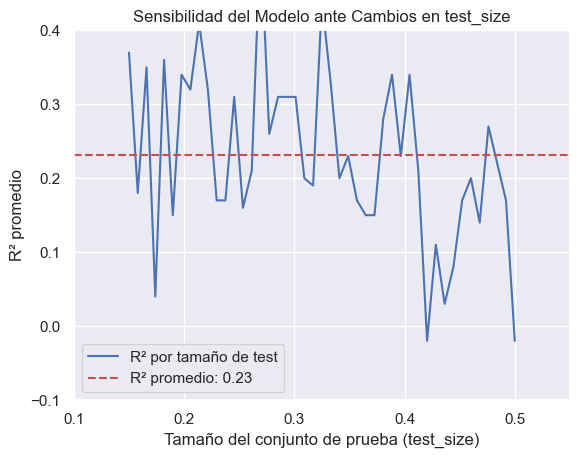

In [ ]:
sizes = np.linspace(0.15, 0.5, 45)
r2 = []
for size in sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size)
    modelo_split = LinearRegression(fit_intercept=True)
    modelo_split.fit(X_train, y_train)
    y_pred = modelo_split.predict(X_test)
    r2.append(round(r2_score(y_test, y_pred), 2))

r2_prom = np.array(r2).mean()

plt.plot(sizes, r2, label='R² por tamaño de test')
plt.axhline(r2_prom, color='r', linestyle='--', label=f'R² promedio: {round(r2_prom, 2)}')
plt.xlim(0.1, 0.55)
plt.ylim(-0.1, 0.4)
plt.xlabel('Tamaño del conjunto de prueba (test_size)')
plt.ylabel('R² promedio')
plt.title('Sensibilidad del Modelo ante Cambios en test_size')
plt.legend()
plt.show()

No parecen tener mucho que ver ... pero, ¿qué pasa si iteramos sobre el mismo tamaño del conjunto de testeo?

Analicemos la sensibilidad al tamaño del conjunto de testeo:

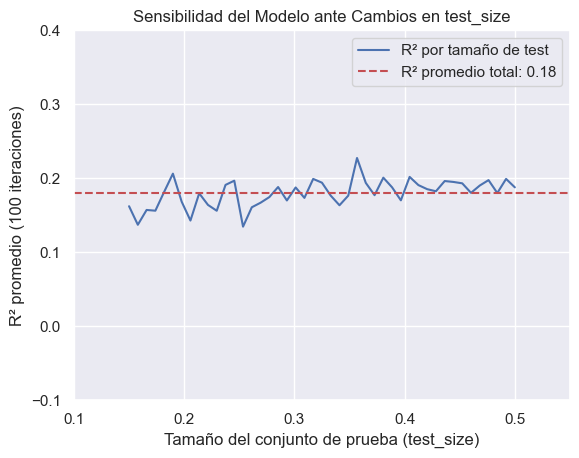

In [ ]:
sizes = np.linspace(0.15, 0.5, 45)
r2 = []
for size in sizes:
    r2_cache = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size)
        modelo_split = LinearRegression(fit_intercept=True)
        modelo_split.fit(X_train, y_train)
        y_pred = modelo_split.predict(X_test)
        r2_cache.append(r2_score(y_test, y_pred))
    r2.append(np.array(r2_cache).mean())

r2_prom = np.array(r2).mean()

plt.plot(sizes, r2, label='R² por tamaño de test')
plt.axhline(r2_prom, color='r', linestyle='--', label=f'R² promedio total: {round(r2_prom, 2)}')
plt.xlim(0.1, 0.55)
plt.ylim(-0.1, 0.4)
plt.xlabel('Tamaño del conjunto de prueba (test_size)')
plt.ylabel('R² promedio (100 iteraciones)')
plt.title('Sensibilidad del Modelo ante Cambios en test_size')
plt.legend()
plt.show()

Claramente el modelo parece tener una baja variabilidad, pues el rango de R² esta entre 0.15 y 0.2.

Esto nos muestra que el modelo es robusto a cambios en el tamaño del conjunto de testeo, por tanto no depende de como se dividan los datos. Sin embargo, la estabilidad no implica buen rendimiento.

Por tanto podriamos concluir que la condición de baño con arrastre de agua como variable predictora explica el 19% de la variabilidad en la sobreedad avanzada en primaria en promedio. Aún así, este resultado era esperable, pues una sola variable predictora era improbable de explicar una variable tan compleja como lo es la sobreedad avanzada en primaria. Esta depende de factores como los ingresos del hogar, el nivel de educación de los padres, etc.: variables que no estamos considerando en nuestro análisis.

Ahora, veamos como evalúa un modelo de esta misma manera pero tomando mas variables predictoras. Tomemos en este caso, la condición de pisos con revestimiento.



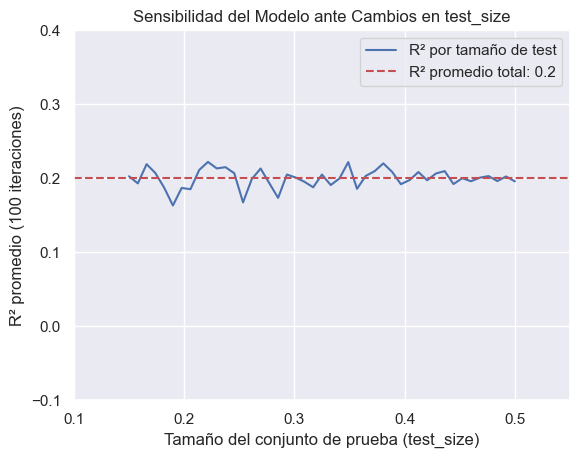

In [ ]:
#Definimos las variables predictoras y el objetivo
X = df_testing[['banio_arrastre', 'piso_revestimiento']]
y = df_testing['sobreedad_avanzada_primaria']

sizes = np.linspace(0.15, 0.5, 45)
r2 = []

for size in sizes:
    r2_cache = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size)
        modelo_split = LinearRegression(fit_intercept=True)
        modelo_split.fit(X_train, y_train)
        y_pred = modelo_split.predict(X_test)
        r2_cache.append(r2_score(y_test, y_pred))
    r2.append(np.array(r2_cache).mean())

r2_prom = np.array(r2).mean()

plt.plot(sizes, r2, label='R² por tamaño de test')
plt.axhline(r2_prom, color='r', linestyle='--', label=f'R² promedio total: {round(r2_prom, 2)}')
plt.xlim(0.1, 0.55)
plt.ylim(-0.1, 0.4)
plt.xlabel('Tamaño del conjunto de prueba (test_size)')
plt.ylabel('R² promedio (100 iteraciones)')
plt.title('Sensibilidad del Modelo ante Cambios en test_size')
plt.legend()
plt.show()

Nuevamente, tenemos un R² aproximando a 0.2.
Veamos como se evalúa con 3 variables. Consideremos la condicion de tener agua por cañeria dentro del hogar:

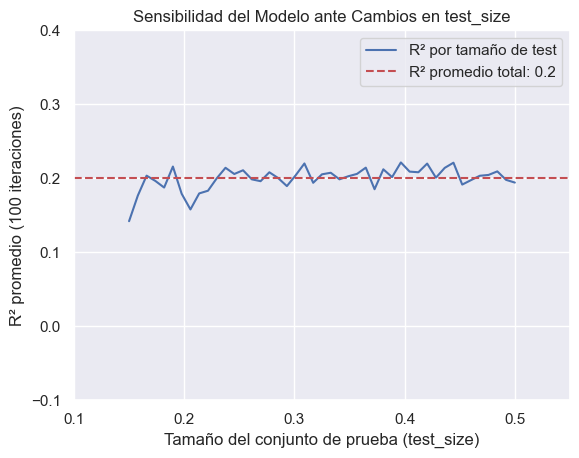

In [ ]:
#Definimos las variables predictoras y el objetivo
X = df_testing[['banio_arrastre', 'piso_revestimiento','agua_canieria_dentro']]
y = df_testing['sobreedad_avanzada_primaria']

sizes = np.linspace(0.15, 0.5, 45)
r2 = []

for size in sizes:
    r2_cache = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size)
        modelo_split = LinearRegression(fit_intercept=True)
        modelo_split.fit(X_train, y_train)
        y_pred = modelo_split.predict(X_test)
        r2_cache.append(r2_score(y_test, y_pred))
    r2.append(np.array(r2_cache).mean())

r2_prom = np.array(r2).mean()

plt.plot(sizes, r2, label='R² por tamaño de test')
plt.axhline(r2_prom, color='r', linestyle='--', label=f'R² promedio total: {round(r2_prom, 2)}')
plt.xlim(0.1, 0.55)
plt.ylim(-0.1, 0.4)
plt.xlabel('Tamaño del conjunto de prueba (test_size)')
plt.ylabel('R² promedio (100 iteraciones)')
plt.title('Sensibilidad del Modelo ante Cambios en test_size')
plt.legend()
plt.show()

¡Notar que no cambia el R²! Por tanto, el modelo explica consistentemente alrededor del 20% de la variabilidad en la sobreedad avanzada, lo que sugiere que las condiciones habitacionales analizadas tienen un impacto débil pero detectable. Sin embargo, este resultado indica que otros factores no incluidos en el modelo juegan un papel más relevante en el atraso escolar.

Esto también es explicado porque las condiciones de saneamiento básicas estan muy correlacionadas entre sí (0.8 ~ 0.9),

In [ ]:
df_testing[['banio_arrastre', 'piso_revestimiento', 'agua_canieria_dentro']].corr()

,banio_arrastre,piso_revestimiento,agua_canieria_dentro
banio_arrastre,1.000000,0.953099,0.924948
piso_revestimiento,0.953099,1.000000,0.888985
agua_canieria_dentro,0.924948,0.888985,1.000000


Por tanto, agregar variables al modelo inicial no aporta información nueva útil.
